In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

import numpy as np

from pytriqs.plot.mpl_interface import plt
plt.rcParams["figure.figsize"] = (6,5) # set default size for all figures

# Square lattice susceptibility

A nice example of two-particle response functions is the two-dimensional square lattice with nearest neighbour hopping $t$. Here we will use `TRIQS` and `TPRF` routines to compute the bare generalized susceptibility

$$\chi_{0, abcd}(i \omega_n, \mathbf{k}) ,$$ 

and the generalized susecptibility in the random phase approximation (RPA) 

$$\chi^{(RPA)}_{abcd}(i\omega_n, \mathbf{k}) .$$

In order to do this we first have to setup the tight binding Hamiltonian $H$, the single particle dispersion $\epsilon(\mathbf{k})$, and the single-particle Green's function $G_0(i\omega_n, \mathbf{k})$ of the system.

## Tight binding Hamiltonian

The tight binding Hamiltonian of the square lattice with nearest neigbhour hopping $t$ takes the form

$$
H = -t \sum_{\langle i, j \rangle, \sigma} 
\Big( c^\dagger_{\sigma i} c_{\sigma j} + 
      c^\dagger_{\sigma j} c_{\sigma i} \Big)
$$

where $c^\dagger_{\sigma i}$ creates a fermion with spin $\sigma \in \{\uparrow, \downarrow\}$ on lattice site $i$, and $\langle i, j \rangle$ denotes summation over nearest neighbours $i$ and $j$.

A representation of $H$ can be constructed using the `TBLattice` class in `triqs_tprf.tight_binding` where the hoppings are given as a dictionary with relative coordinate vectors as keys and hopping matrices as values. The unit vectors of the lattice, the position of the site local orbitals and names also needs to be setup, see below.

In [2]:
from triqs_tprf.tight_binding import TBLattice

t = 1.0
H = TBLattice(
    units = [(1, 0, 0), (0, 1, 0)],
    hopping = {
        # nearest neighbour hopping -t
        ( 0,+1): -t * np.eye(2),
        ( 0,-1): -t * np.eye(2),
        (+1, 0): -t * np.eye(2),
        (-1, 0): -t * np.eye(2),
        },
    orbital_positions = [(0,0,0)]*2,
    orbital_names = ['up', 'do'],
    )

Starting on 1 Nodes at : 2018-06-14 11:47:05.837080


## Dispersion $\epsilon(\mathbf{k})$ and Fermi surface

The Fourier transform of the real space hopping to momentum space $\mathbf{k}$ gives the momentum space dispersion $\epsilon(\mathbf{k})$ and the alternative representation of $H$ as

$$
H = \sum_{\mathbf{k}} 
\epsilon(\mathbf{k}) c^\dagger_{\sigma \mathbf{k}} c_{\sigma \mathbf{k}}
$$

In order to work with $\epsilon(\mathbf{k})$ numerically we use a discretized representation with an equidistant mesh in $k_x$ and $k_y$ using the `TRIQS` mesh `MeshBrillouinZone`

In [3]:
e_k = H.on_mesh_brillouin_zone(n_k = (64, 64, 1))
print(e_k)

Green Function  with mesh Brillouin Zone Mesh with linear dimensions (64 64 1), Domain: Brillouin Zone with repiprocal matrix 
[[6.28319,0,0]
 [0,6.28319,0]
 [0,0,6.28319]] and target_rank 2: 



To visualize $\epsilon(\mathbf{k})$ we can plot it along the high-symmetry path $\Gamma - X - M - \Gamma$ in the Brillouin zone.

To build the $\mathbf{k}$-space path we use the helper function `triqs_tprf.lattice_utils.k_space_path`

In [4]:
G = np.array([0.0, 0.0, 0.0]) * 2.*np.pi
X = np.array([0.5, 0.5, 0.0]) * 2.*np.pi
M = np.array([0.5, 0.0, 0.0]) * 2.*np.pi

paths = [(G, X), (X, M), (M, G)]

from triqs_tprf.lattice_utils import k_space_path
k_vecs, k_plot, K_plot = k_space_path(paths)
kx, ky, kz = k_vecs.T

and to evaluate $\epsilon(\mathbf{k})$ on the path we use a lambda function and the call operator of `e_k([k_x, k_y, k_z])` which interpolates on the discretized mesh.

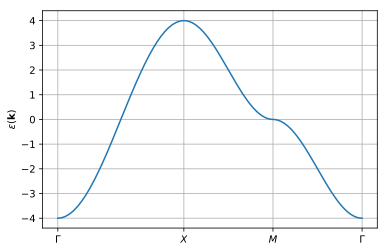

In [5]:
e_k_interp = np.vectorize(
    lambda kx, ky, kz : e_k([kx, ky, kz])[0, 0].real)    
e_k_interp = e_k_interp(kx, ky, kz)

plt.plot(k_plot, e_k_interp, '-')
plt.axes().set_xticks(K_plot)
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$',r'$\Gamma$'])
plt.ylabel(r'$\epsilon(\mathbf{k})$'); plt.grid()

From this we can see that the bandwidth is $4t$ (with $t=1$) and that we have a van Hoove singularity at the $M$ point.

To visualize the dispersion in the $(k_x, k_y)$ plane and the half-filled fermi surface where $\epsilon(\mathbf{k}) = 0$ we interpolate `e_k` on a two-dimensional grid and use `matplotlib.pyplot.contour` to plot the zero contour.

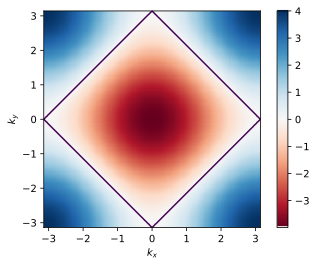

In [6]:
k = np.linspace(-0.5, 0.5, num=200) * 2. * np.pi
Kx, Ky = np.meshgrid(k, k)

e_k_interp = np.vectorize(lambda kx, ky : e_k([kx, ky, 0])[0, 0].real)    
e_k_interp = e_k_interp(Kx, Ky)

plt.figure()
extent = (k.min(), k.max(), k.min(), k.max())
plt.imshow(e_k_interp, cmap=plt.get_cmap('RdBu'),
           extent=extent, origin='lower')
plt.colorbar()
plt.contour(Kx, Ky, e_k_interp, levels=[0])
plt.xlabel(r'$k_x$'); plt.ylabel(r'$k_y$');

I.e. the Fermi surface has a diamond shape with perfect nesting of the fermi surface for the momentum transfer vectors $\mathbf{k}=\pm(\pi, \pi)$ and $\mathbf{k}=\pm(\pi, -\pi)$.

## Bare generalized susceptibility $\chi_0$

The bare generalized (particle-hole) susceptibility $\chi_0$ is defined as the bubble diagram of a propagating particle hole excitation, i.e.

$$
\chi_0(\tau, \mathbf{r}) = - G(\tau, \mathbf{r}) G(-\tau, -\mathbf{r})
$$

where $G$ is the single-particle Green's function.

For a non-interacting system the single particle Green's function $G_0$ is known analytically

$$
G_0(i\omega_n, \mathbf{k}) =
\frac{1}{ i\omega_n + \mu - \epsilon(\mathbf{k}) }
$$

and the product of two Green's functions can be performed analytically using the Lindhard formula

$$
  \chi_0(\omega_n, \mathbf{q}) =
  \frac{1}{N_k} \sum_{\mathbf{k}} 
   \frac{ f(\epsilon(\mathbf{k})) - f(\epsilon(\mathbf{k}+\mathbf{q})) }
	    {i\omega_n + \epsilon(\mathbf{k} + \mathbf{q}) - \epsilon(\mathbf{k}) }
$$

where $f(\cdot)$ is the Fermi distribution function. 

For reference this formula is implemented in `TPRF`, for details on the generalization to multiorbital and accidentally denerate dispersion see the documentation for `lindhard_chi00_wk`.

In [7]:
from triqs_tprf.lattice import lindhard_chi00_wk
chi00_wk_analytic = lindhard_chi00_wk(e_k=e_k, beta=5.0, mu=0., nw=1)

A computationally more efficient way of computing $\chi_0$ is to perform the product of two single-particle Green's functions in imaginary time and real space and then fourier transform back to frequency and momentum space, i.e.

$$
\chi_0(i\omega_n, \mathbf{k}) = 
\mathcal{F}_{ \{ \tau, \mathbf{r} \} \rightarrow \{ i\omega_n, \mathbf{k} \} } 
\{ -G(\tau, \mathbf{r}) G(-\tau, -\mathbf{r}) \}
$$

To do this we first construct the single particle Green's function of the lattice using the lattice Dyson equation

$$
G(i\omega_n, \mathbf{k})  =
\Big[ i\omega_n + \mu - \epsilon(\mathbf{k}) - \Sigma(i\omega_n) \Big]^{-1}
$$

assuming a momentum independent self energy $\Sigma(i\omega_n, \mathbf{k}) \approx \Sigma(i\omega_n)$.

In [8]:
from pytriqs.gf import MeshImFreq, Idx
from triqs_tprf.lattice import lattice_dyson_g0_wk

wmesh = MeshImFreq(beta=5.0, S='Fermion', n_max=30)
g0_wk = lattice_dyson_g0_wk(mu=0., e_k=e_k, mesh=wmesh)

And then perform the bubble product using the dedictated function

In [9]:
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
chi00_wk = imtime_bubble_chi0_wk(g0_wk, nw=1)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 5.0
nk    = 4096
nw    = 60
norb  = 2

Approx. Memory Utilization: 0.07 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_w0r_from_grt_PH (bubble in tau & r)
--> chi_wk_from_chi_wr (r->k)


## Physical response function $\chi_{S_z, S_z}$

From the generalized susceptibility $\chi_{abcd}(i\omega_n, \mathbf{k})$ we can obtain any two particle response function by contracting the rank 4 tensor indices with two quadratic operators. E.g. the spin-spin response along the z-axis is given by

$$
\chi_{S_z, S_z} = \text{Tr}[ S_z \, \chi \, S_z ]
$$

In [10]:
def chi_SzSz_contraction(chi):
    """ Computes the trace Tr[ S_z \chi S_z ]"""
    Sz = np.diag([+0.5, -0.5])
    chi_SzSz = chi[0, 0, 0, 0].copy()
    chi_SzSz.data[:] = np.einsum('wqabcd,ab,cd->wq', chi.data, Sz, Sz)[:, :]
    chi_SzSz = chi_SzSz[Idx(0), :]
    return chi_SzSz

To look at the structure of $\chi_0$ we can plot it along the high symmetry path in the Brillouin zone (using the call operator of a triqs Green's function on `MeshBrillouinZone`).

In [11]:
def interpolate_chi(chi, k_vecs):
    assert( k_vecs.shape[1] == 3 )
    chi_interp = np.zeros(
        [k_vecs.shape[0]] + list(chi.target_shape), dtype=np.complex)

    for kidx, (kx, ky, kz) in enumerate(k_vecs):
        chi_interp[kidx] = chi((kx, ky, kz))

    return chi_interp

Whit some additional plot helper functions we can now look at the spin-spin response

In [20]:
def plot_chi_1D(chi, label=None):

    chi_SzSz = chi_SzSz_contraction(chi)
    chi_interp = interpolate_chi(chi_SzSz, k_vecs)

    plt.plot(k_plot, chi_interp.real, label=label)
    
    plt.grid()
    plt.axes().set_xticks(K_plot)
    plt.xlim([K_plot.min(), K_plot.max()])
    plt.axes().set_xticklabels([r'$\Gamma$',r'$M$',r'$X$',r'$\Gamma$'])    
    plt.title(r'Spin-response $\chi_{S_z S_z}(\mathbf{q}, \omega=0)$')

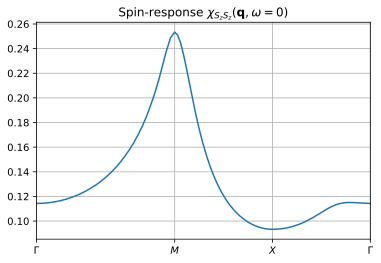

In [21]:
plot_chi_1D(chi00_wk, label=r'$U=0$')

In [22]:
def plot_chi(chi, label=None):

    k = np.linspace(-0.75, 0.75, num=100) * 2.*np.pi
    Kx, Ky = np.meshgrid(k, k)
    k_vecs = np.vstack((Kx.flatten(), Ky.flatten(), 0*Kx.flatten())).T

    chi_SzSz = chi_SzSz_contraction(chi)
    chi_interp = interpolate_chi(chi_SzSz, k_vecs)
    chi_interp = chi_interp.real.reshape(Kx.shape)

    plt.imshow(
        chi_interp, cmap=plt.get_cmap('magma'),
        extent=(k.min(), k.max(), k.min(), k.max()),
        origin='lower', vmin=0, vmax=chi_interp.max())

    plt.title(label); plt.colorbar()
    plt.xlabel(r'$k_x$'); plt.ylabel(r'$k_y$')

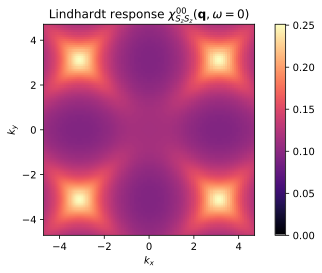

In [23]:
label = r'Lindhardt response $\chi^{00}_{S_z S_z}(\mathbf{q}, \omega=0)$'
plot_chi(chi00_wk, label=label)
plt.tight_layout()

# Random phase approximation (RPA)

The full Bethe-Salpeter equation in the particle-hole channel has the form

$$ \chi^{(PH)} = \chi_0 + \chi_0 \Gamma^{(PH)} \chi^{(PH)} $$

where all components are momentum and (three) frequency dependent quantities. In the random phase approximation (RPA) the vertex is apprximated by the (frequency independent) local interaction $\Gamma^{(PH)} \approx V$. 

The locality and frequency independence simplifies the BSE which formally is solved as

$$ [ 1 - \chi_0 V ]^{-1} \, \chi_0 = \chi $$

in `TPRF` there is the dedicated routine for RPA (`triqs_tprf.lattice.solve_rpa_PH`) that can treat the general multiorbital case.

For generality we take the nessecary steps to obtain the four index tensor $V$ from the operator expression of the Hubbard interaction.

In [24]:
from pytriqs.operators import n, c
H_int = n(0, 0) * n(0, 1)
fundamental_operators = [c(0, 0), c(0, 1)]

from pyed.OperatorUtils import quartic_tensor_from_operator
from pyed.OperatorUtils import quartic_permutation_symmetrize
V_int_abcd = quartic_tensor_from_operator(H_int, fundamental_operators)
V_int_abcd = quartic_permutation_symmetrize(V_int_abcd)

V_abcd = np.zeros_like(V_int_abcd)
from itertools import product
for a, b, c, d in product(range(V_abcd.shape[0]), repeat=4):
    V_abcd[a, b, c, d] = V_int_abcd[b, d, a, c]

Now we can tune the interaction strength and compute the corresponding RPA generalized susceptibility.

In [25]:
from triqs_tprf.lattice import solve_rpa_PH

chi_wk_vec = []
U_vec = np.arange(1.0, 5.0, 1.0)
for u in U_vec:
    chi_wk = solve_rpa_PH(chi00_wk, u * V_abcd)
    chi_wk_vec.append(chi_wk)

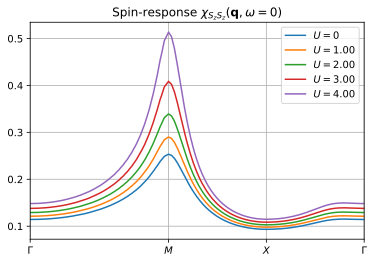

In [26]:
plot_chi_1D(chi00_wk, label=r'$U=0$')

for U, chi_wk in zip(U_vec, chi_wk_vec):
    plot_chi_1D(chi_wk, label=r'$U=%2.2f$' % U)

plt.legend();

We see that the system has an instability at the $M$ point 

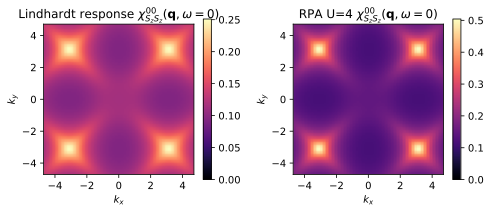

In [27]:
plt.figure(figsize=(7, 3))
subp = [1, 2, 1]

plt.subplot(*subp); subp[-1] += 1
label = r'Lindhardt response $\chi^{00}_{S_z S_z}(\mathbf{q}, \omega=0)$'
plot_chi(chi00_wk, label=label)

plt.subplot(*subp); subp[-1] += 1
label=r'RPA U=%1.0f $\chi^{00}_{S_z S_z}(\mathbf{q}, \omega=0)$' % U_vec[-1]
plot_chi(chi_wk_vec[-1], label=label)

plt.tight_layout()